In [1]:
import os
import torch
import torch.nn as nn
import torchvision
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import torchvision.utils as utils
import matplotlib.pyplot as plt
import import_ipynb
from calculate_fid import calculate_fid_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
class Generator(nn.Module):
    def __init__(self, text_dim, noise_dim):
        super().__init__()
        self.text_processor = nn.Sequential(
            nn.Linear(text_dim, 256),
            nn.ReLU(),
        )
        
        self.generator_network = nn.Sequential(
            nn.Linear(noise_dim + 256, 512 * 4 * 4),
            nn.BatchNorm1d(512 * 4 * 4),
            nn.ReLU(),
            nn.Unflatten(dim=1, unflattened_size=(512, 4, 4)),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, text_input, noise_input):
        text_processor = self.text_processor(text_input)
        final_input = torch.cat([noise_input, text_processor], dim=1)
        return self.generator_network(final_input)

gen = Generator(119, 100).to(device)

In [3]:
class Discriminator(nn.Module):
    def __init__(self, text_dim):
        super().__init__()
        self.text_encoder = nn.Sequential(
            nn.Linear(text_dim, 256),
            nn.ReLU(),
        )
        self.disc_network = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
        )
        self.final_network = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 4 * 4 + 256, 1),
            nn.Sigmoid(),
        )

    def forward(self, image_input, text_input):
        text_encoder = self.text_encoder(text_input).view(-1, 256)
        image_features = self.disc_network(image_input).view(image_input.size(0), -1)
        final_features = torch.cat([image_features, text_encoder], dim=1)
        return self.final_network(final_features)

dis = Discriminator(119).to(device)

In [4]:
def initialize_weights(model):
    classname = model.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)
        
gen.apply(initialize_weights)
dis.apply(initialize_weights)

optim_gen = torch.optim.Adam(gen.parameters(), lr = 0.0002, betas=(0.5, 0.999))
optim_dis = torch.optim.Adam(dis.parameters(), lr = 0.0002, betas=(0.5, 0.999))
loss_function = nn.BCELoss()

gen.train()

Generator(
  (text_processor): Sequential(
    (0): Linear(in_features=119, out_features=256, bias=True)
    (1): ReLU()
  )
  (generator_network): Sequential(
    (0): Linear(in_features=356, out_features=8192, bias=True)
    (1): BatchNorm1d(8192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Unflatten(dim=1, unflattened_size=(512, 4, 4))
    (4): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): ConvTranspose2d(64, 3, kern

In [5]:
dis.train()

Discriminator(
  (text_encoder): Sequential(
    (0): Linear(in_features=119, out_features=256, bias=True)
    (1): ReLU()
  )
  (disc_network): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(256, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
  )
  (final_network): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=8448, o

In [6]:
#Loading CIFR10 dataset
t = transforms.Compose([transforms.Resize(64), transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
cifr_dataset = torchvision.datasets.CIFAR10(root='./data', download=True, transform=t)
cifr_loader = DataLoader(cifr_dataset, batch_size=128, shuffle=True)

Files already downloaded and verified


In [7]:
#Training Generator and Discriminator
    
# Initialize variables
gen_losses = []
dis_losses = []
saved_images = []
fid_scores = []
count = 0
fixed_noise = torch.randn(32, 100, device=device)
fixed_text_input = torch.randn(32, 119, device=device)

output_dir = 'output_DCGAN'
os.makedirs(output_dir, exist_ok=True)

# Start training
epoch = 0
while epoch < 40:
    for idx, (img, _) in enumerate(cifr_loader):
        real_images = img.to(device)
        batch_size = real_images.size(0)
        real_labels = torch.full((batch_size,), 1, dtype=torch.float, device=device)
        fake_labels = torch.full((batch_size,), 0, dtype=torch.float, device=device)

        # Train Discriminator
        dis.zero_grad()
        # Real data
        dis_output_real = dis(real_images, torch.randn(batch_size, 119, device=device)).view(-1)
        loss_dis_real = loss_function(dis_output_real, real_labels)
        loss_dis_real.backward()

        # Fake data
        noise = torch.randn(batch_size, 100, device=device)
        input_text = torch.randn(batch_size, 119, device=device)
        fake_images = gen(input_text, noise)
        dis_output_fake = dis(fake_images.detach(), input_text).view(-1)
        loss_dis_fake = loss_function(dis_output_fake, fake_labels)
        loss_dis_fake.backward()
        optim_dis.step()
        loss_dis_total = loss_dis_real + loss_dis_fake
        dis_losses.append(loss_dis_total.detach().cpu())
        
        #Train Generator
        gen.zero_grad()
        gen_output = dis(fake_images, input_text).view(-1)
        loss_gen = loss_function(gen_output, real_labels)
        loss_gen.backward()
        optim_gen.step()

        gen_losses.append(loss_gen.detach().cpu())

        # Save generated images at intervals
        if (count % 300 == 0) or ((epoch == 39) and (idx == len(cifr_loader) - 1)):
            with torch.no_grad():
                sample_images = gen(fixed_text_input, fixed_noise).detach().cpu()
            saved_images.append(utils.make_grid(sample_images, padding=2, normalize=True))

        count += 1

    # Calculate FID score after each epoch
    with torch.no_grad():
        fid_score = calculate_fid_score(real_images.cpu(), fake_images.cpu())
    fid_scores.append(fid_score)

    if epoch%5 == 0:
        print(f'\nEpoch [{epoch}/40] '
              f'Loss Generator: {loss_gen.item():.3f}, Loss Discriminator: {loss_dis_total.item():.3f}, '
              f'FID Score: {fid_score:.3f}')
        with torch.no_grad():
            sample_epoch_images = gen(fixed_text_input, fixed_noise).detach()
        
    fake_image_path = os.path.join(output_dir, f'fake_samples_epoch_{epoch + 1:03d}.png')
    real_image_path = os.path.join(output_dir, f'real_samples_epoch_{epoch + 1:03d}.png')
    
    utils.save_image(sample_epoch_images.detach(), fake_image_path, normalize=True)
    utils.save_image(real_images.detach(), real_image_path, normalize=True)

    epoch += 1

with open(os.path.join(output_dir, 'gen_losses.txt'), 'w') as file:
    for loss in gen_losses:
        file.write(f"{loss}\n")

with open(os.path.join(output_dir, 'dis_losses.txt'), 'w') as file:
    for loss in dis_losses:
        file.write(f"{loss}\n")

with open(os.path.join(output_dir, 'fid_scores.txt'), 'w') as file:
    for score in fid_scores:
        file.write(f"{score}\n")

print('Training completed successfully!')

/home/lmadipa/.conda/envs/pytorch_env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lmadipa/.conda/envs/pytorch_env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch [0/40] Loss Generator: 5.146, Loss Discriminator: 0.502, FID Score: 374.530

Epoch [5/40] Loss Generator: 2.392, Loss Discriminator: 0.575, FID Score: 275.849

Epoch [10/40] Loss Generator: 1.982, Loss Discriminator: 1.429, FID Score: 290.724

Epoch [15/40] Loss Generator: 5.106, Loss Discriminator: 0.038, FID Score: 272.847

Epoch [20/40] Loss Generator: 5.187, Loss Discriminator: 0.334, FID Score: 252.404

Epoch [25/40] Loss Generator: 4.486, Loss Discriminator: 0.052, FID Score: 248.824

Epoch [30/40] Loss Generator: 7.857, Loss Discriminator: 0.010, FID Score: 264.960

Epoch [35/40] Loss Generator: 4.672, Loss Discriminator: 0.038, FID Score: 267.382
Training completed successfully!


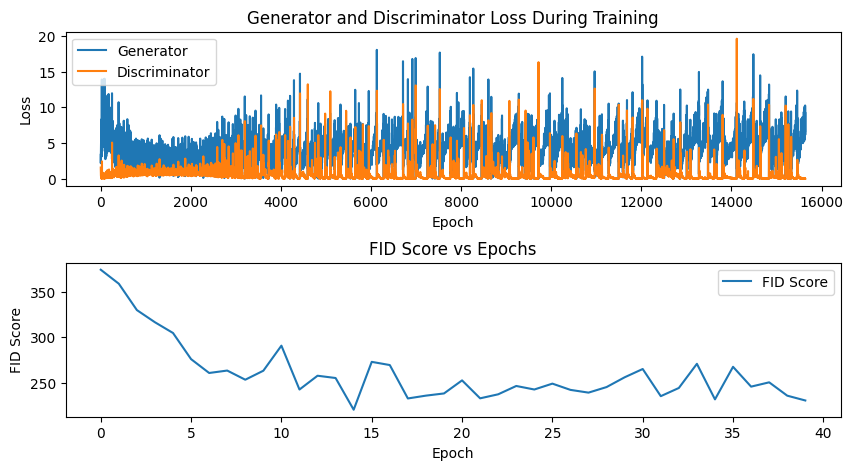

In [10]:
#Plotting Graphs

plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(gen_losses, label="Generator")
plt.plot(dis_losses, label="Discriminator")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Generator and Discriminator Loss During Training")

plt.subplot(2, 1, 2)
plt.plot(range(40), fid_scores, label="FID Score")
plt.xlabel("Epoch")
plt.ylabel("FID Score")
plt.legend()
plt.title("FID Score vs Epochs")

plt.subplots_adjust(hspace=0.5)

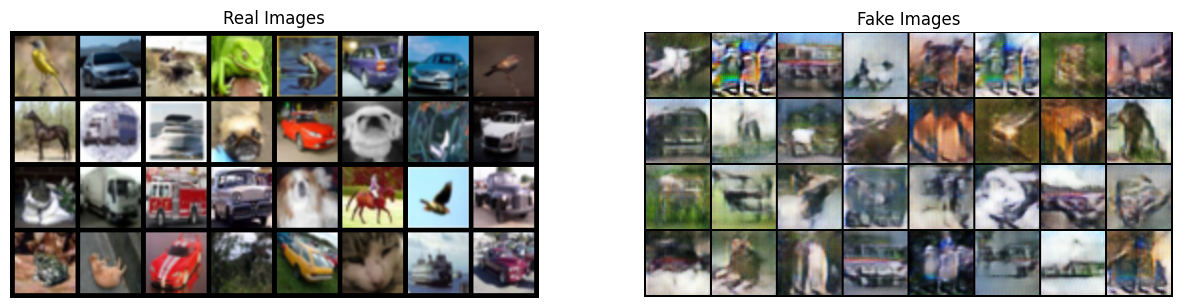

In [11]:
r_batch = next(iter(cifr_loader))

plt.figure(figsize=(15,15))

plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(utils.make_grid(r_batch[0].to(device)[:32], padding=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(saved_images[-1],(1,2,0)))

plt.savefig('output_DCGAN/DCGAN_32_FAKE_IMAGES.png', format='png', bbox_inches='tight')
plt.show()